In [23]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42

import bbi
import pybedtools as pbt
import pickle
import cooler
from copy import deepcopy
import itertools 

import sys
sys.path.append("./code")

from tad_functions import *
from treg_functions import *
from hic_zscore_functions import *
from plotting_functions import *
from aux_functions import *
from init_tss_annotations import *
gpath = './annotations/chromsizes'
import statsmodels.stats
import statsmodels.stats.multitest


In [24]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2


In [25]:
import bbi

bw_pref = '/Genomics/argo/users/gdolsten/pritlab/snakemake_sras/bws/'

bbi_dict = {
    'Treg H3K27ac' : bbi.open(bw_pref + 'GSM.SRR5385344.H3K27ac_ChIP-seq_of_Treg_replicate_2.bw'),
    'Tcon H3K27ac' : bbi.open(bw_pref + 'GSM.SRR5385346.H3K27ac_ChIP-seq_of_Tconv_replicate_2.bw'),
}

In [26]:
from initialize import *

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)


In [27]:
from abc_score import *
from config import *

my_tss_df = pd.read_csv('./annotations/my_tss_df.csv', index_col=0)
tss_5kb_ind_df = make_tss_ind_df(all_ind_to_region_5kb, my_tss_df)

import pandas as pd
geneLengths = pd.read_csv('./gene_expression/gene_lengths.txt', sep='\t', skiprows=1,).set_index("Geneid")
geneLengths = geneLengths['Length']

gene_dict = load_bulkrna(my_tss_df, geneLengths)

In [28]:
from abc_score import compute_ABC_scores
from initialize import *

treg_5kb = cooler.Cooler('./Treg_all.mcool::/resolutions/5000')
tcon_5kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/5000')

(_, _, _, _, _, all_ind_to_region_5kb, chrom_to_start_5kb, chrom_to_end_5kb) = initialize_helper_vars(treg_5kb)
goodind_regions = pbt.BedTool(all_ind_to_region_5kb)

In [29]:
bw = bbi_dict['Treg H3K27ac']
chrom, s, e = trans(add_chr_to_bedtool(goodind_regions))
treg_h3k27ac_5kb = bw.stackup(chrom, s, e, bins=1)

bw = bbi_dict['Tcon H3K27ac']
chrom, s, e = trans(add_chr_to_bedtool(goodind_regions))
tcon_h3k27ac_5kb = bw.stackup(chrom, s, e, bins=1)

In [30]:
from abc_score import compute_ABC_scores

treg_intra_activity_dfs, treg_inter_activity_dfs = compute_ABC_scores(treg_5kb, treg_h3k27ac_5kb, chrom_to_start_5kb, 
                                                                      chrom_to_end_5kb, parsed_chroms, use_chr=False, res=5_000
                                                                     )

tcon_intra_activity_dfs, tcon_inter_activity_dfs = compute_ABC_scores(tcon_5kb, tcon_h3k27ac_5kb, chrom_to_start_5kb, 
                                                                      chrom_to_end_5kb, parsed_chroms, use_chr=False, res=5_000
                                                                     )

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with X
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with X


In [31]:
treg_intra_activity_dfs_roll, treg_inter_activity_dfs_roll = compute_ABC_scores(treg_5kb, np.roll(treg_h3k27ac_5kb, 40, axis=0), chrom_to_start_5kb, 
                                                                      chrom_to_end_5kb, parsed_chroms, use_chr=False, res=5_000
                                                                     )

tcon_intra_activity_dfs_roll, tcon_inter_activity_dfs_roll = compute_ABC_scores(tcon_5kb, np.roll(tcon_h3k27ac_5kb, 40, axis=0), chrom_to_start_5kb, 
                                                                      chrom_to_end_5kb, parsed_chroms, use_chr=False, res=5_000
                                                                     )


Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with X
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with X


In [32]:
from abc_score import *

treg_intra_activity_dfs_diagrand_hic, treg_inter_activity_dfs_diagrand_hic = compute_ABC_scores(treg_5kb, treg_h3k27ac_5kb, chrom_to_start_5kb, 
                                                                      chrom_to_end_5kb, parsed_chroms, use_chr=False, res=5_000,
                                                                                randomize_hic='diagrandom'
                                                                     )

tcon_intra_activity_dfs_diagrand_hic, tcon_inter_activity_dfs_diagrand_hic = compute_ABC_scores(tcon_5kb, tcon_h3k27ac_5kb, chrom_to_start_5kb, 
                                                                      chrom_to_end_5kb, parsed_chroms, use_chr=False, res=5_000,
                                                                                                randomize_hic='diagrandom'
                                                                     )

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with X
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with X


In [34]:
all_genesoi = []
for chrom in parsed_chroms:
    if chrom == 'X':
        continue
    genesoi = tss_5kb_ind_df[tss_5kb_ind_df['chr'] == chrom].index.intersection(
        gene_dict['Resting'].reset_index()['name'].values    
    ).intersection(geneLengths.index)
    all_genesoi.extend(genesoi)

all_genesoi.remove('Trmt44')
all_genesoi.remove('Pcdhga8')

### Figure S4A (Baseline): Normalization: Shift H3K27ac

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python

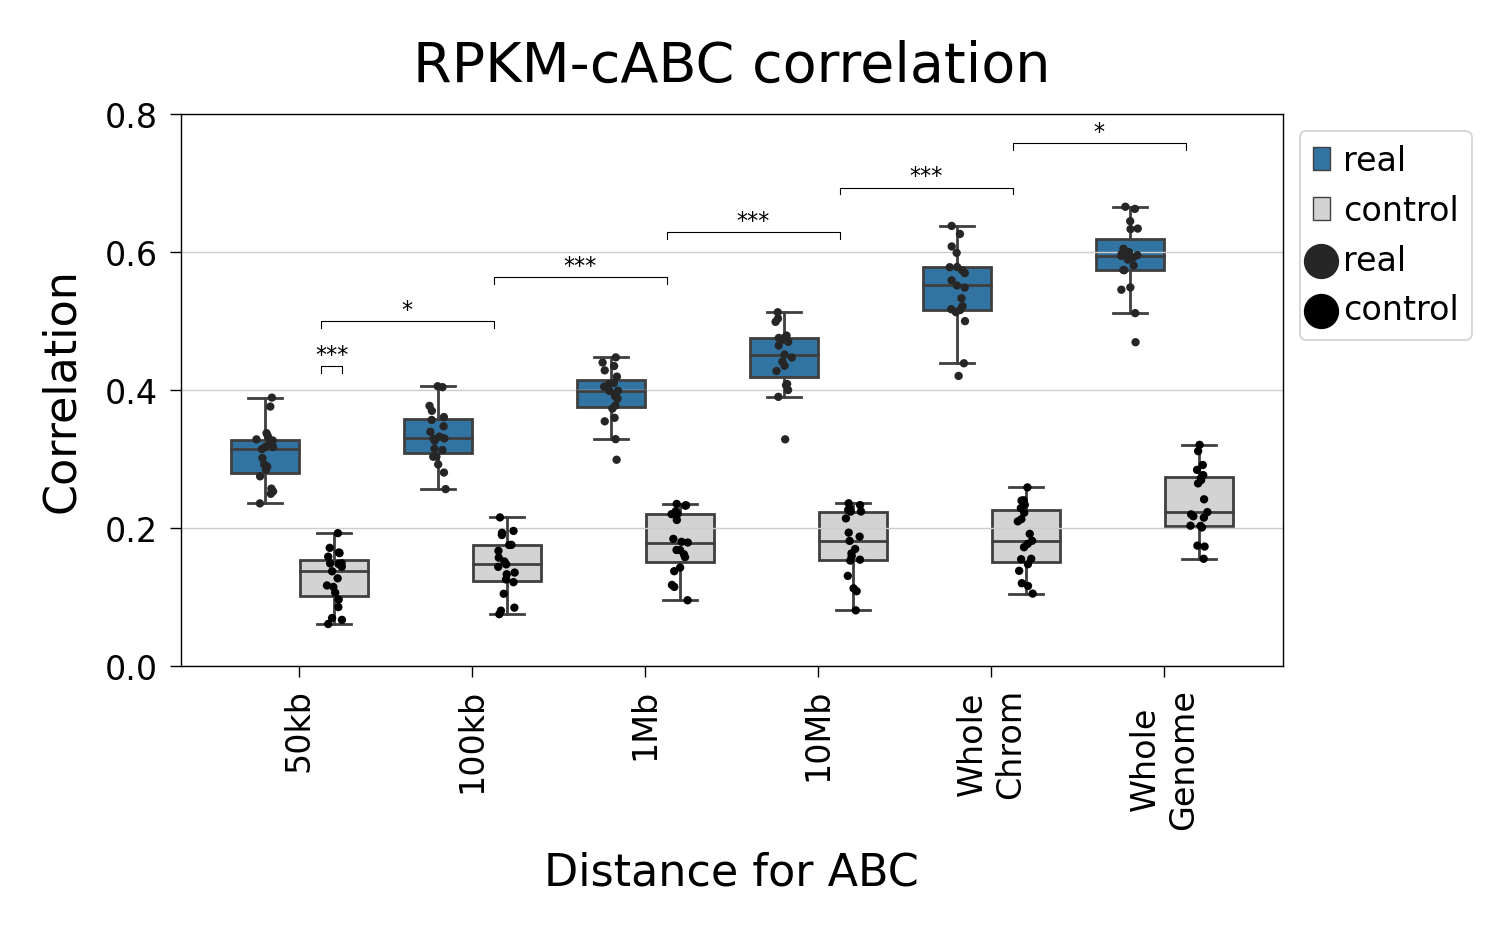

In [35]:
from abc_score import plot_abc4

fig = plot_abc4(treg_intra_activity_dfs, treg_intra_activity_dfs_roll, 
                treg_inter_activity_dfs, treg_inter_activity_dfs_roll, all_genesoi,
                tss_5kb_ind_df, gene_dict['Resting'].reset_index(), geneLengths, parsed_chroms,
         ylims = [0, .8])
# fig.savefig('./plots/ABC/ABC_gene_correlation_cumulative_inter.pdf', bbox_inches = 'tight')    

### Figure S5C (LFC): Normalization: Shift H3K27ac

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtyp

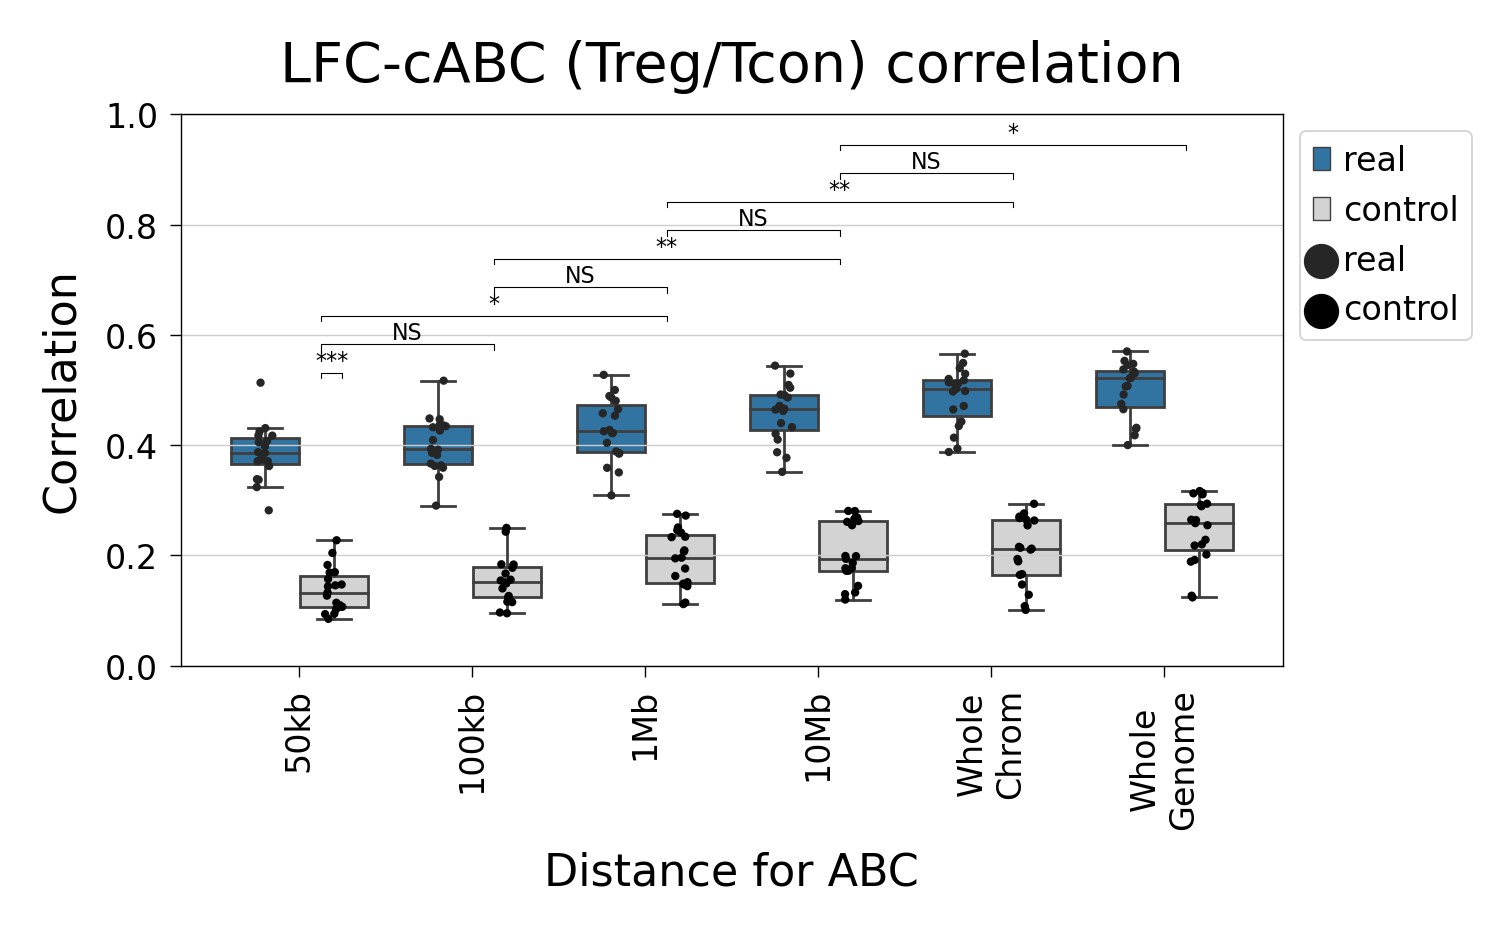

In [36]:
from abc_score import plot_abc_lfc

fig = plot_abc_lfc(treg_intra_activity_dfs, treg_intra_activity_dfs_roll, 
                   treg_inter_activity_dfs, treg_inter_activity_dfs_roll,
                   tcon_intra_activity_dfs, tcon_intra_activity_dfs_roll, 
                   tcon_inter_activity_dfs, tcon_inter_activity_dfs_roll, all_genesoi,
                   tss_5kb_ind_df, gene_dict['Resting'].reset_index(), parsed_chroms,
         ylims = [0, .8])
# fig.savefig('./plots/ABC/ABC_gene_correlation_cumulative_lfc.pdf', bbox_inches = 'tight')    

### Figure S5B (Baseline): Normalization: Shuffle Hi-C along diagonal

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python

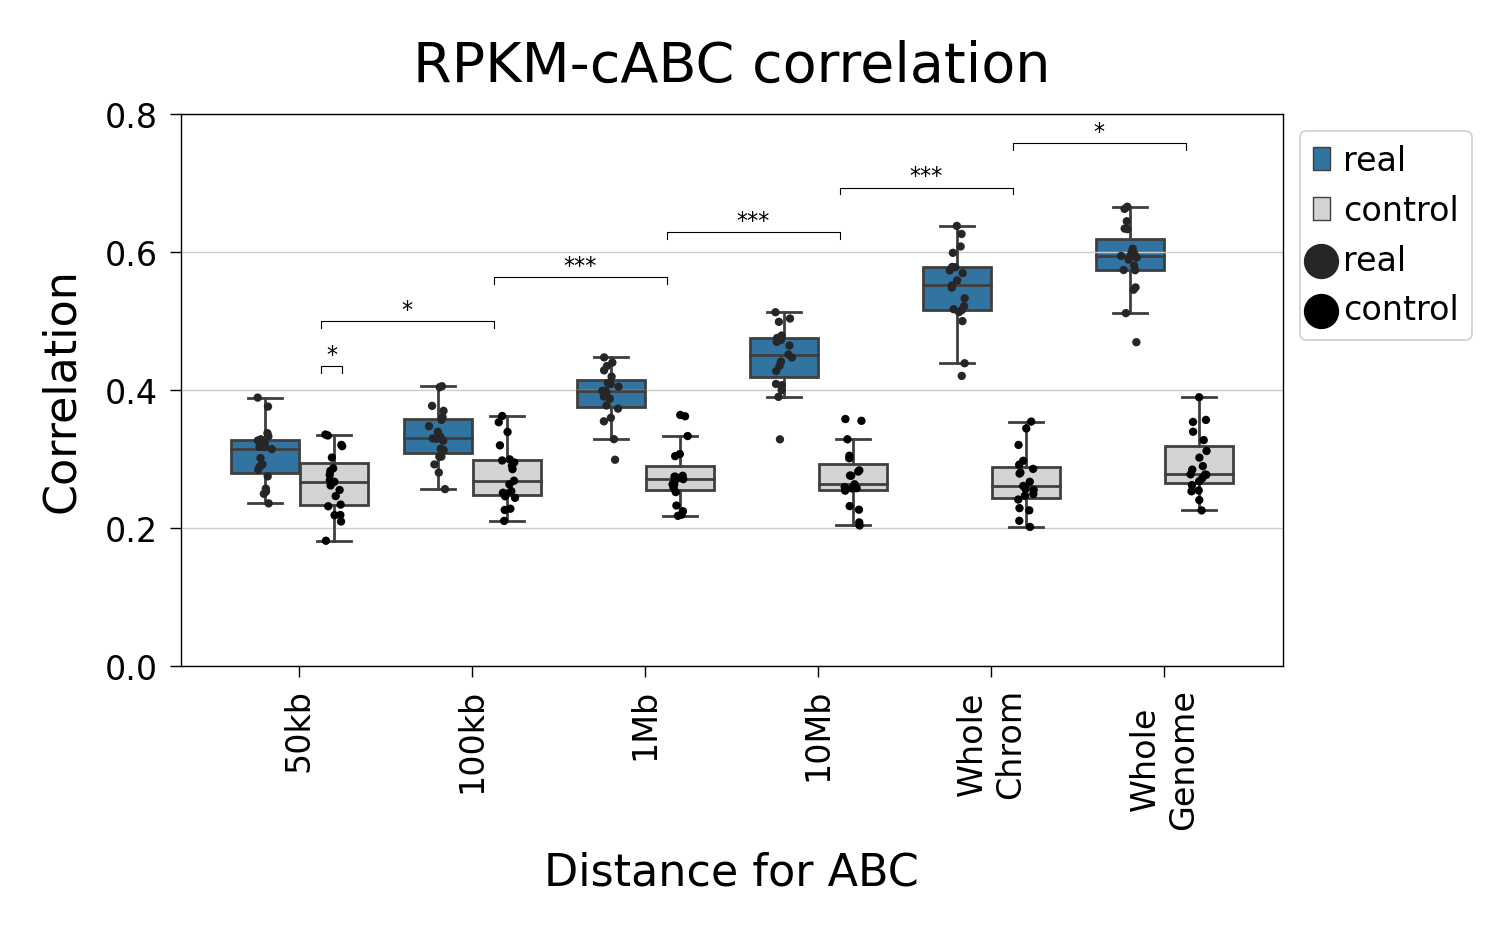

In [37]:
%autoreload 2
from abc_score import plot_abc4

fig = plot_abc4(treg_intra_activity_dfs, treg_intra_activity_dfs_diagrand_hic, 
                treg_inter_activity_dfs, treg_inter_activity_dfs_diagrand_hic, all_genesoi,
                tss_5kb_ind_df, gene_dict['Resting'].reset_index(), geneLengths, parsed_chroms,
         ylims = [0, .8])

### Figure S5D (LFC): Normalization: Shuffle Hi-C along diagonal

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python

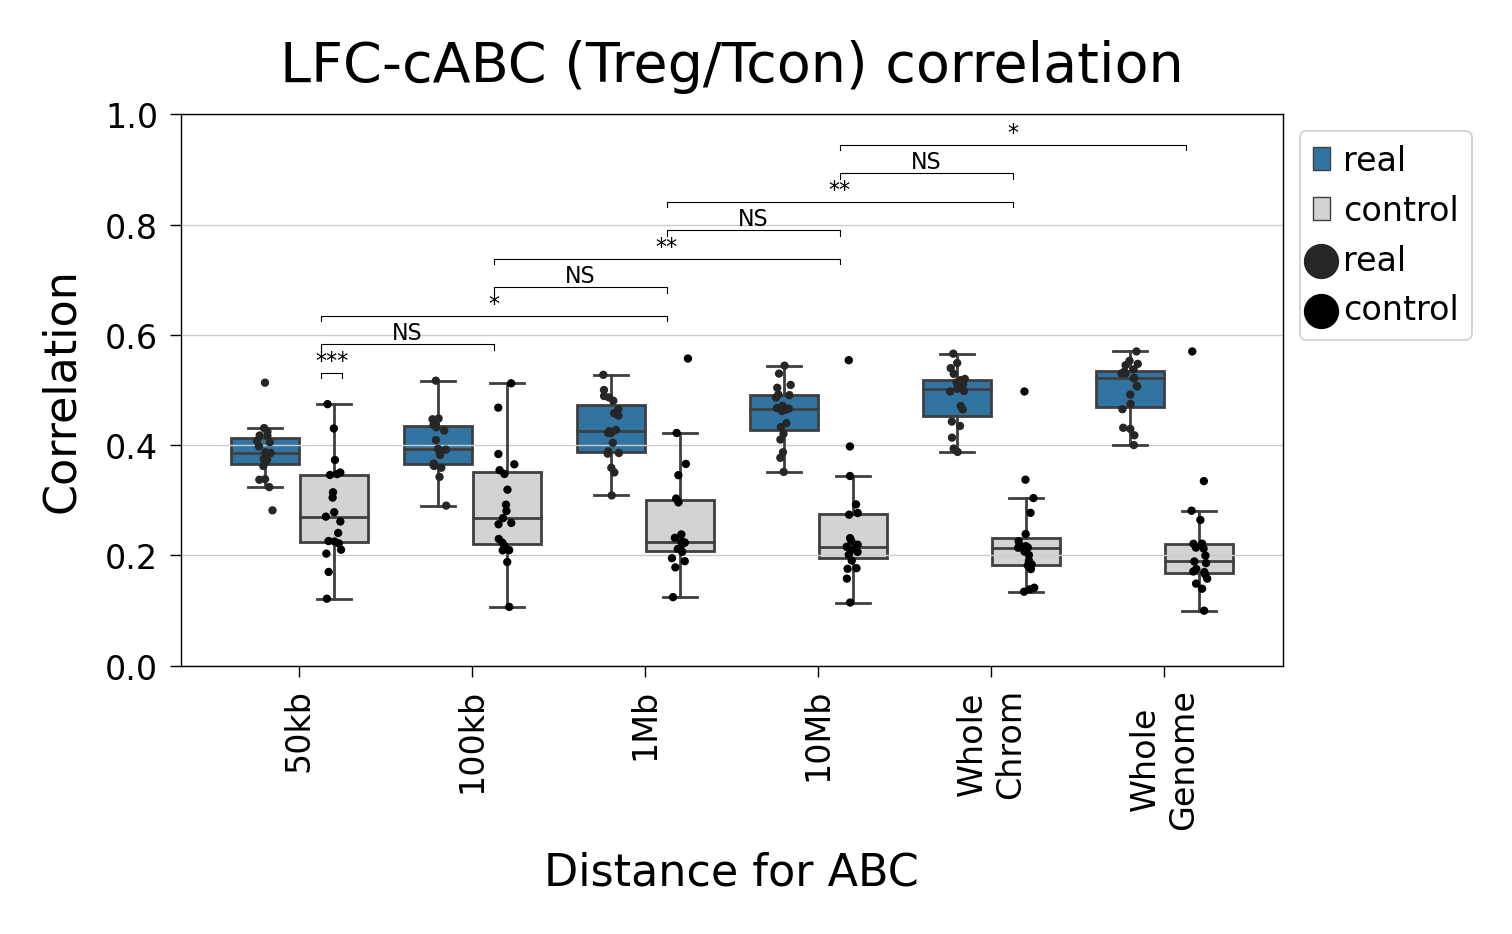

In [38]:
from abc_score import plot_abc_lfc

fig = plot_abc_lfc(treg_intra_activity_dfs, treg_intra_activity_dfs_diagrand_hic, 
                   treg_inter_activity_dfs, treg_inter_activity_dfs_diagrand_hic,
                   tcon_intra_activity_dfs, tcon_intra_activity_dfs_diagrand_hic, 
                   tcon_inter_activity_dfs, tcon_inter_activity_dfs_diagrand_hic, all_genesoi,
                   tss_5kb_ind_df, gene_dict['Resting'].reset_index(), parsed_chroms,
         ylims = [0, .8])
# fig.savefig('./plots/ABC/ABC_gene_correlation_lfc_diagrand.pdf', bbox_inches = 'tight')    

Look at total amounts of cABC

In [39]:
from abc_score import make_ternary_df
treg_ternary_dfs = make_ternary_df(treg_intra_activity_dfs, treg_inter_activity_dfs, all_ind_to_region_5kb, tss_5kb_ind_df,
                                   TSS_filter=True, genesets=[all_genesoi])

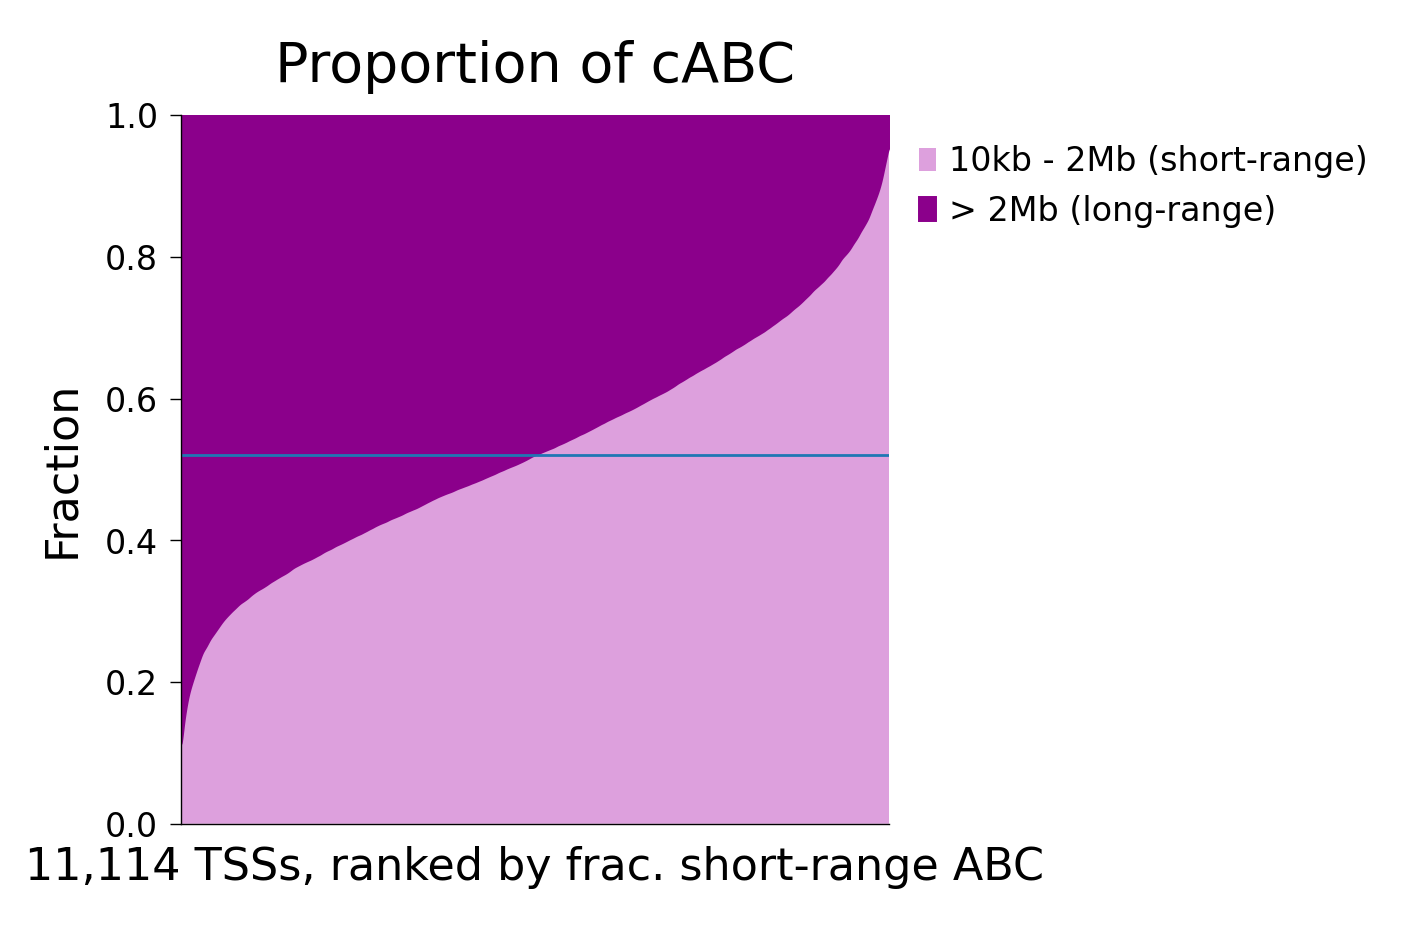

In [42]:
v = pd.concat(treg_ternary_dfs, axis=0).sort_values(["Local", 'Far', "Inter"]).iloc[:, :2]
v = (v.T / v.sum(axis=1)).T
v = v.sort_values("Local")
v = v.cumsum(axis=1)
v = v.apply(lambda x: scipy.ndimage.gaussian_filter1d(x, sigma=25))
# v.columns = ['10kb - 2Mb (Intra)', '> 2Mb (Intra)', 'All Inter']
v.columns = ['10kb - 2Mb (short-range)', '> 2Mb (long-range)']

xs = np.arange(len(v))
colors = ['plum', 'darkmagenta', 'tab:green']
fig, axs = init_subplots_exact(1, 1, fgsz=(45*mm, 45*mm), dpi = 200)
for c, column in enumerate(v.columns):
    if c == 0:
        axs.fill_between(xs, [0], v[column], rasterized=True, #linewidth=1, edgecolor='black',
                         facecolor=colors[c], label=column
                        )
    else:
        axs.fill_between(xs, v.iloc[:, c-1], v.iloc[:, c], rasterized=True, #linewidth=1, edgecolor='white'
                         color=colors[c], label=column
                        )
plt.axhline(np.nanmedian(v['10kb - 2Mb (short-range)']))
plt.xlim([xs[0], xs[-1]+1])
plt.xticks([]);
plt.gca().grid(False)
plt.ylabel("Fraction")
plt.title("Proportion of cABC")
plt.legend(bbox_to_anchor=(1, 1), frameon=False, loc='upper left')
plt.xlabel(f"{len(v):,} TSSs, ranked by frac. short-range ABC")
plt.ylim([0, 1])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

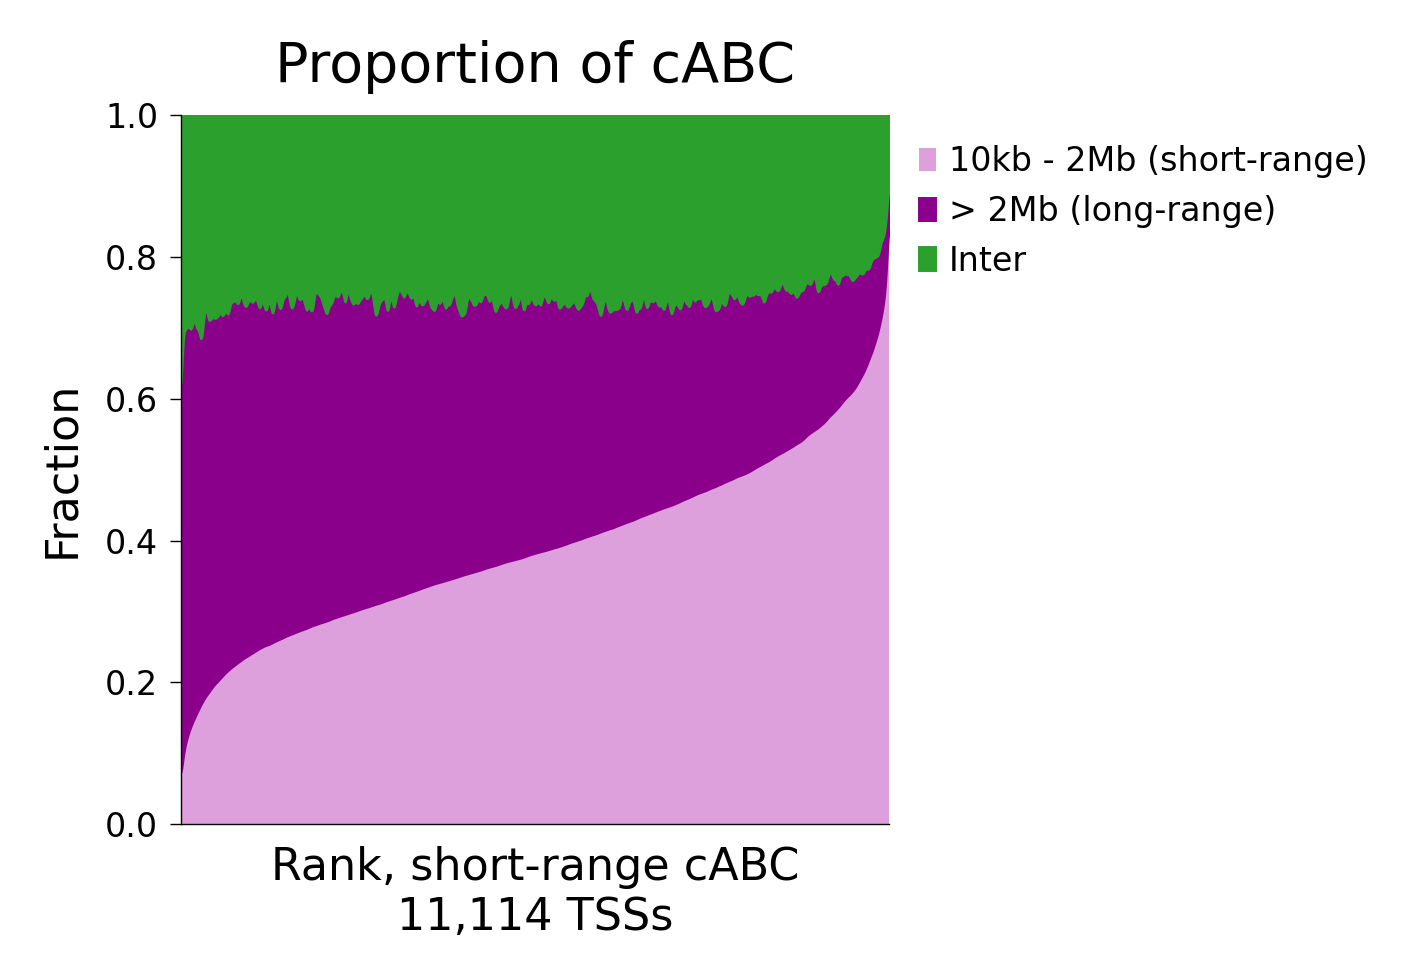

In [43]:
v = pd.concat(treg_ternary_dfs, axis=0).sort_values(["Local", 'Far', "Inter"]).iloc[:, :3]
# v = v.drop("Inter", axis=1)
v = (v.T / v.sum(axis=1)).T
v = v.sort_values("Local")

v = v.cumsum(axis=1)
v = v.apply(lambda x: scipy.ndimage.gaussian_filter1d(x, sigma=25))
# v.columns = ['10kb - 2Mb (Intra)', '> 2Mb (Intra)', 'All Inter']
v.columns = ['10kb - 2Mb (short-range)', '> 2Mb (long-range)', 'Inter']

xs = np.arange(len(v))
colors = ['plum', 'darkmagenta', 'tab:green']
fig, axs = init_subplots_exact(1, 1, fgsz=(45*mm, 45*mm), dpi = 200)
for c, column in enumerate(v.columns):
    if c == 0:
        axs.fill_between(xs, [0], v[column], rasterized=True, #linewidth=1, edgecolor='black',
                         facecolor=colors[c], label=column
                        )
    else:
        axs.fill_between(xs, v.iloc[:, c-1], v.iloc[:, c], rasterized=True, #linewidth=1, edgecolor='white'
                         color=colors[c], label=column
                        )
# plt.axhline(np.nanmedian(v['10kb - 2Mb (short-range)']))
plt.xlim([xs[0], xs[-1]+1])
plt.xticks([]);
plt.gca().grid(False)
plt.ylabel("Fraction")
plt.title("Proportion of cABC")
plt.legend(bbox_to_anchor=(1, 1), frameon=False, loc='upper left')
plt.xlabel(f"Rank, short-range cABC\n{len(v):,} TSSs")
plt.ylim([0, 1])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# plt.savefig('./plots/FINAL_LOOP/ABC_longrange_shortrange.svg', dpi=200)